In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from splits import split_users # contains split_users func

pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 100)

In [2]:
# read in pickled DFs generated by query_dfs.py

df_orders = pd.read_pickle("./pickle/df_orders.pickle")
df_train = pd.read_pickle("./pickle/df_train.pickle")
df_prior = pd.read_pickle("./pickle/df_prior.pickle")
df_prod_detail = pd.read_pickle("./pickle/df_prod_detail.pickle")

In [3]:
# read in pickled feature DF generated by feature_engineering_1.ipynb
X = pd.read_pickle("./pickle/X_15.pickle")

In [4]:
X.sample(2)

,product_id,user_id,num_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,user_avg_spacing,user_avg_time,order_hour_of_day_avg,days_since_prior_order_avg
5866877,28427,88635,2,"[19677, 5760, 13176, 45446, 42014, 41674, 4177...",0,"[19677, 15872, 24097, 13176, 8174]",0,8996,0.711983,5.365607,9.058824,22.0,14,13.461039,15.807947
3593527,24852,40184,10,"[27845, 24852, 47144, 21903, 35383, 37664]",1,"[21903, 49683, 24852, 11777, 35383, 34969, 241...",1,472565,0.843501,4.894129,6.533333,30.0,11,14.316327,17.833333


### Picking up where we left off...

**More. Features.**

* `streak`: how many times in a row has this user ordered this item?
    * this feature is very computationally expensive to add
    * implemented multiprocessing to complete in ~5 minutes. 
    * see `add_streaks.py` for details
    


In [5]:
df_streaks = pd.read_csv("../data/order_streaks.csv")
df_streaks.rename(columns={"order_streak": "streak"}, inplace=True)
df_streaks.head(3)

,user_id,product_id,streak
0,1,196,5.0
1,1,12427,5.0
2,1,10258,5.0


Negative streaks indicate the number of weeks since the user last ordered the given product.

In [6]:
X = X.merge(df_streaks, how='left', on=['user_id', 'product_id'])

In [7]:
(X[['product_id', 'user_id', 'num_orders', 'streak']]
     .sample(10))

,product_id,user_id,num_orders,streak
7905765,39092,42559,1,-4.0
2668266,47209,4682,1,-2.0
6922205,10061,12218,2,2.0
1147526,8193,9550,1,1.0
6591104,39751,34187,2,1.0
4638600,22275,59677,1,-4.0
5598819,25877,3273,1,NaN
5159700,43490,49186,1,NaN
3898935,10246,169138,1,-3.0
4886694,27801,101804,1,NaN


(array([510435., 629405., 804176., 968287.,      0., 982615., 189233.,
         83041.,  39380.,  64719.]),
 array([-4. , -3.1, -2.2, -1.3, -0.4,  0.5,  1.4,  2.3,  3.2,  4.1,  5. ]),
 <BarContainer object of 10 artists>)

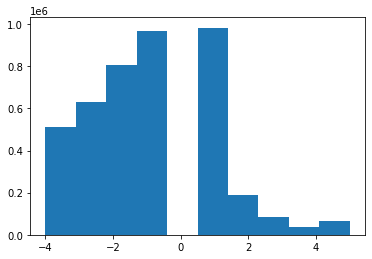

In [8]:
import matplotlib.pyplot as plt
plt.hist(X.streak)

In [9]:
X.streak.value_counts().sort_index()

-4.0    510435
-3.0    629405
-2.0    804176
-1.0    968287
 1.0    982615
 2.0    189233
 3.0     83041
 4.0     39380
 5.0     64719
Name: streak, dtype: int64

Awesome! Now we have an `order_streak` column. But if the user has never purchased the given item in the past, the resulting value is `NaN`. Since we have negative streaks that may help our model, we can't replace the `NaNs` with zeros.

Instead, let's consider this a categorical variable. Let's assign a value to the NaNs and then use pd.get_dummies to split the results.

In [10]:
mask = X.streak == np.NaN
X[mask].shape

(0, 16)

In [14]:
X['streak'] = X.streak.astype(str)
X['streak'] = X['streak'].fillna(value='NA')
X

In [21]:
dummies = pd.get_dummies(X.streak, prefix='streak', drop_first=True)
dummies.head(3)

,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan
0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1


In [29]:
dumb_names = list(dummies.columns)
X[dumb_names] = pd.get_dummies(X.streak, prefix='streak', drop_first=True)
X.drop(columns='streak', inplace=True)
X.head(3)

,product_id,user_id,num_orders,cart,in_cart,last_cart,in_last_cart,prod_prior_sales,prod_pct_reorders,prod_avg_atco,user_avg_ippo,user_avg_spacing,user_avg_time,order_hour_of_day_avg,days_since_prior_order_avg,streak_-2.0,streak_-3.0,streak_-4.0,streak_1.0,streak_2.0,streak_3.0,streak_4.0,streak_5.0,streak_nan
0,1,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,1852,0.613391,5.801836,4.625,1.0,12,12.689189,10.4,1,0,0,0,0,0,0,0,0
1,907,138,2,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2025,0.554568,3.653333,4.625,1.0,12,12.689189,10.4,0,0,0,0,0,0,0,0,1
2,1000,138,1,[42475],0,"[46802, 22128, 40199, 21573, 26152, 12341]",0,2610,0.408046,9.503448,4.625,1.0,12,12.689189,10.4,0,0,0,0,0,0,0,0,1


In [30]:
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


X_tr, X_te, y_tr, y_te = split_users(X)

lr = LogisticRegression(solver='lbfgs', max_iter=200)
lr.fit(X_tr, y_tr)
f1_score(lr.predict(X_te), y_te)

Actual Test Size: 0.2001


0.12116890856461775

In [31]:
X.shape

(8474661, 24)